In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from joblib import dump as jdump
import time
import random
import os

In [ ]:
PATH2PROJECT = "/content/drive/MyDrive/Projects/EyeTracker/"
raw_models_dir = PATH2PROJECT + "models/eye_tracking/raw/"
trained_models_dir = PATH2PROJECT + "models/eye_tracking/trained/"
scaler_dir = PATH2PROJECT + "models/eye_tracking/trained/scalers.bin"
MODEL_FOL = "model1"
R_TRAIN = 0.9
CHOSEN_INPUTS = [0, 1, 2, 6, 7, 8, 9]
N_EPOCHS = 200
PATIENCE = 25
MIN_BRIGHTNESS_RATIO = 0.7
MAX_BRIGHTNESS_RATIO = 1.4

In [ ]:
x1_load = []
x2_load = []
y_load = []
dataset_dir = PATH2PROJECT + "dataset/"
datasets_folders = os.listdir(dataset_dir)

for data_fol in datasets_folders:
    with open(dataset_dir + data_fol +
              "/eye_tracking_calibration_modified/x1.pickle", "rb") as f:
        x1_load0 = pickle.load(f)
    with open(dataset_dir + data_fol +
              "/eye_tracking_calibration_modified/x2.pickle", "rb") as f:
        x2_load0 = pickle.load(f)
    with open(dataset_dir + data_fol +
              "/eye_tracking_calibration_modified/y.pickle", "rb") as f:
        y_load0 = pickle.load(f)
    for (x10, x20, y10) in zip(x1_load0, x2_load0, y_load0):
        x1_load.append(x10)
        x2_load.append(x20)
        y_load.append(y10)

x1_load = np.array(x1_load)
x2_load = np.array(x2_load)
y_load = np.array(y_load)

n_samples, frame_height, frame_width = x1_load.shape[:-1]
print(n_samples, frame_height, frame_width)

24500 48 44


In [ ]:
x1_chg_bri = x1_load.copy()
for (i, _) in enumerate(x1_chg_bri):
    r = random.uniform(MIN_BRIGHTNESS_RATIO, MAX_BRIGHTNESS_RATIO)
    x1_chg_bri[i] = (x1_chg_bri[i] * r).astype(np.uint8)

In [ ]:
x2_chs_inp = x2_load[:, CHOSEN_INPUTS]

[-2.92097984  0.01450496 -0.1692337   0.51821423  0.47875661  0.51987594
  0.49142322]
[2995.  948.]


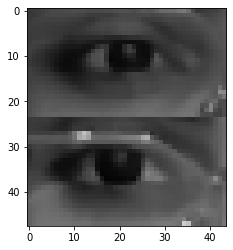

In [ ]:
SAMPLE_NUMBER = 2
print(x2_chs_inp[SAMPLE_NUMBER])
print(y_load[SAMPLE_NUMBER])
plt.imshow(x1_chg_bri[SAMPLE_NUMBER].reshape((frame_height, frame_width)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

In [ ]:
x1_scaler = 255
x1 = x1_chg_bri / x1_scaler

x2_scaler = StandardScaler()
x2 = x2_scaler.fit_transform(x2_chs_inp)

y_scalers = y_load.max(0)
y = y_load / y_scalers

scalers = [x1_scaler, x2_scaler, y_scalers]
jdump(scalers, scaler_dir)

['/content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/scalers.bin']

In [ ]:
y1, y2 = y[:, 0], y[:, 1]

In [ ]:
x1_shf, x2_shf, y1_shf, y2_shf = shuffle(x1, x2, y1, y2)

n_train = int(R_TRAIN * n_samples)
n_test = n_samples - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y1_train, y2_train = y1_shf[:n_train], y2_shf[:n_train]
y1_test, y2_test = y1_shf[n_train:], y2_shf[n_train:]

print(x1_train.shape, x1_test.shape, y1_train.shape, y1_test.shape,
      x2_train.shape, x2_test.shape, y2_train.shape, y2_test.shape)

(22050, 48, 44, 1) (2450, 48, 44, 1) (22050,) (2450,) (22050, 7) (2450, 7) (22050,) (2450,)


In [ ]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]
y_train_list = [y1_train, y2_train]
y_test_list = [y1_test, y2_test]

In [ ]:
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [ ]:
model = load_model(raw_models_dir + MODEL_FOL)
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 48, 44, 16)   416         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 24, 22, 16)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 24, 22, 32)   12832       max_pooling2d_12[0][0]           
____________________________________________________________________________________________

In [ ]:
model.fit(x_train_list,
          y_train_list,
          validation_data=(x_test_list, y_test_list),
          epochs=N_EPOCHS,
          callbacks=cb)

Epoch 1/200
690/690 [==============================] - 39s 12ms/step - loss: 0.2981 - dense_53_loss: 0.1147 - dense_54_loss: 0.1834 - val_loss: 0.2116 - val_dense_53_loss: 0.0783 - val_dense_54_loss: 0.1334
Epoch 2/200
690/690 [==============================] - 8s 12ms/step - loss: 0.1953 - dense_53_loss: 0.0741 - dense_54_loss: 0.1212 - val_loss: 0.1794 - val_dense_53_loss: 0.0636 - val_dense_54_loss: 0.1158
Epoch 3/200
690/690 [==============================] - 8s 12ms/step - loss: 0.1708 - dense_53_loss: 0.0657 - dense_54_loss: 0.1051 - val_loss: 0.1639 - val_dense_53_loss: 0.0632 - val_dense_54_loss: 0.1007
Epoch 4/200
690/690 [==============================] - 8s 12ms/step - loss: 0.1566 - dense_53_loss: 0.0612 - dense_54_loss: 0.0954 - val_loss: 0.1478 - val_dense_53_loss: 0.0567 - val_dense_54_loss: 0.0911
Epoch 5/200
690/690 [==============================] - 8s 11ms/step - loss: 0.1455 - dense_53_loss: 0.0577 - dense_54_loss: 0.0878 - val_loss: 0.1465 - val_dense_53_loss: 0.05

In [ ]:
yhat_train_list = model.predict(x_train_list)
yhat_test_list = model.predict(x_test_list)

y_train = np.concatenate((np.expand_dims(y_train_list[0], 1),
                          np.expand_dims(y_train_list[1], 1)), 1)
yhat_train = np.concatenate((yhat_train_list[0], yhat_train_list[1]), 1)
y_test = np.concatenate((np.expand_dims(y_test_list[0], 1),
                          np.expand_dims(y_test_list[1], 1)), 1)
yhat_test = np.concatenate((yhat_test_list[0], yhat_test_list[1]), 1)

In [ ]:
train_loss = np.abs(y_train - yhat_train).sum(0) / n_train
test_loss = np.abs(y_test - yhat_test).sum(0) / n_test

In [ ]:
model.save(trained_models_dir + MODEL_FOL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/EyeTracker/models/eye_tracking/trained/model4/assets
